In [1]:
!pip install -q geopandas

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="ticks", color_codes=True)

In [2]:
path_to_data = 'data/green_taxi_prepare___/'
path_to_geoinfo = 'shape/'

In [3]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import array, lit, rand

import pandas as pd
import numpy as np

from tqdm.auto import tqdm
from IPython.display import clear_output

import pickle

import geopandas as gpd

In [37]:
taxi_zone = gpd.read_file('data/shape/taxi_zones.shp')
taxi_zone = taxi_zone.set_index('OBJECTID')
taxi_zone['lon_center'] = taxi_zone.geometry.centroid.x
taxi_zone['lat_center'] = taxi_zone.geometry.centroid.y
taxi_zone = taxi_zone[['lon_center', 'lat_center']]

In [5]:
MEMORY_SIZE = '5g'
spark = SparkSession \
    .builder \
    .config('spark.driver.memory', MEMORY_SIZE) \
    .appName('spark-taxi') \
    .getOrCreate()

In [6]:
data = spark.read.parquet(path_to_data)
#data.cache()
data.show(3)
data.printSchema()

+-------------------+------------+------+-------------------+------------+------------------+-----------------+
|           datetime|       state|action|             reward|  next_state|     duration_trip|             fare|
+-------------------+------------+------+-------------------+------------+------------------+-----------------+
|2019-06-28 03:39:19| [243, 3, 6]|   243| -901.7806545153607| [244, 6, 6]|198.31666666666666| 9.80267881797262|
|2019-06-07 08:55:16| [243, 8, 6]|   243| -71.79497935103652| [244, 9, 6]|27.033333333333335| 8.37168731563016|
|2019-06-30 16:24:01|[243, 16, 1]|   243|-29.165280925105023|[244, 16, 1]|13.116666666666667|6.418052408228307|
+-------------------+------------+------+-------------------+------------+------------------+-----------------+
only showing top 3 rows

root
 |-- datetime: timestamp (nullable = true)
 |-- state: struct (nullable = true)
 |    |-- location: integer (nullable = true)
 |    |-- hour: integer (nullable = true)
 |    |-- weekday:

In [7]:
# train_data = data.filter('datetime >= "2019-12"')
# test_data = data.filter('datetime >= "2019-12"')

train_data = data
test_data = data

In [8]:
train_data = train_data.select(array('state.*').alias('state'),
                   'action',
                   'reward',
                   array('next_state.*').alias('next_state'),
                   'duration_trip', 'fare').cache()

test_data = test_data.select(array('state.*').alias('state'),
                   'action',
                   'reward',
                   array('next_state.*').alias('next_state'),
                   'duration_trip', 'fare').cache()

In [9]:
class SparkDataset:

    def __init__(self, df):
        self.df = df

    def sample_generator(self):
        gen = self.df.orderBy(rand()).toLocalIterator()
        for sample in gen:
            yield {'state': tuple(sample['state']), 'action': sample['action'], 'reward': sample['reward'], 
                   'next_state': tuple(sample['next_state']), 'duration_trip': sample['duration_trip'], 
                  'fare': sample['fare']}

    def __iter__(self):
        return self.sample_generator()

In [10]:
class TaxiEnv:
    
    def __init__(self, dataset):
        self.env = defaultdict(lambda: defaultdict(list))
        i = 0
        for sample in dataset:
            
            s = sample['state']
            a = sample['action']
            r = sample['fare']
            next_s = sample['next_state']
            d = sample['duration_trip']
            
            self.env[s][a].append((next_s, r, d))
            i += 1
        print(i)
            
        self.state_count = len(self.env.keys())
        
    def step(self, state, action):
        if self.env[state][action]:
            x = list(map(list, zip(*self.env[state][action])))
            i = np.random.choice(len(x[2]))
            next_state = x[0][i]
            reward = x[1][i]
            duration = x[2][i]
        else:
            reward = 0.
            duration = 0.
            next_state = self.get_random_state()
        return next_state, reward, duration
    
    def get_random_state(self):
        i = np.random.choice(self.state_count)
        key = list(self.env.keys())[i]
        return key

In [11]:
class SimpleAgent:
    
    def __init__(self, best_actions=[7]):
        self.best_actions = best_actions

    def get_best_action(self, state):
        action = np.random.choice(self.best_actions)
        return int(action)

In [38]:
class SimpleAgent_v2:
    
    def __init__(self, best_actions=[7,74]):
        self.best_actions = best_actions

    def get_best_action(self, state):
        if state[0] in taxi_zone.index:
            state_lon, state_lat = taxi_zone.loc[state[0]]
            dists = {}
            for action in self.best_actions:
                dx = state_lon - taxi_zone.loc[action, 'lon_center']
                dy = state_lat - taxi_zone.loc[action, 'lat_center']
                dists[action] = ((dx)**2 + (dy)**2)**0.5
            return min(dists, key=dists.get)
        else:
            return 7

In [13]:
def generate_session(agent, env, t_max=8*60):
    reward = 0
    duration = 0
    state = env.get_random_state()
    i = 0
    while duration < t_max and i < 300:
        action = agent.get_best_action(state)
        next_s, r, d = env.step(state, action)
        reward += r
        duration += d
        state = next_s
        i += 1
    
    if duration:
        return reward / (duration / 60)
    else:
        return 0

In [14]:
from collections import defaultdict
import numpy as np

from numpy.random import default_rng
rg = default_rng(12345)


class QLearningAgent:
    def __init__(self, alpha, discount, possible_actions, transform=None):
        """
        Q-Learning Agent
        based on https://inst.eecs.berkeley.edu/~cs188/sp19/projects.html
        Instance variables you have access to
          - self.alpha (learning rate)
          - self.discount (discount rate aka gamma)

        Functions you should use
          - self.get_legal_actions(state) {state, hashable -> list of actions, each is hashable}
            which returns legal actions for a state
          - self.get_qvalue(state,action)
            which returns Q(state,action)
          - self.set_qvalue(state,action,value)
            which sets Q(state,action) := value
        !!!Important!!!
        Note: please avoid using self._qValues directly. 
            There's a special self.get_qvalue/set_qvalue for that.
        """

        self.possible_actions = possible_actions
        self._qvalues = defaultdict(lambda: defaultdict(lambda: 0))
        self.alpha = alpha
        self.discount = discount
        
        self.transform = transform
            

    def get_qvalue(self, state, action):
        """ Returns Q(state,action) """
        return self._qvalues[state][action]
        

    def set_qvalue(self, state, action, value):
        """ Sets the Qvalue for [state,action] to the given value """
        self._qvalues[state][action] = value
        

    def get_value(self, state):
        """
        Compute your agent's estimate of V(s) using current q-values
        V(s) = max_over_action Q(state,action) over possible actions.
        Note: please take into account that q-values can be negative.
        """

        q_values = [self.get_qvalue(state, action) for action in self.possible_actions]
        return max(q_values)

    def update(self, state, action, reward, next_state):
        """
        You should do your Q-Value update here:
           Q(s,a) := (1 - alpha) * Q(s,a) + alpha * (r + gamma * V(s'))
        """
        if self.transform:
            state = self.transform(state)
            next_state = self.transform(next_state)
            
        # agent parameters
        gamma = self.discount
        learning_rate = self.alpha
        value = self.get_value(next_state)
        q_value = (1.0 - learning_rate) * self.get_qvalue(state, action) + learning_rate * (reward + gamma * value)

        self.set_qvalue(state, action, q_value)


    def get_best_action(self, state):
        """
        Compute the best action to take in a state (using current q-values). 
        """
        
        if self.transform:
            state = self.transform(state)

        q_values = {action: self.get_qvalue(state, action) for action in self.possible_actions}

        return max(q_values, key=q_values.get)

In [15]:
train_dataset = SparkDataset(train_data)
test_dataset = SparkDataset(test_data)

In [16]:
test_env = TaxiEnv(test_dataset)

828844


In [43]:
simple_agent = SimpleAgent_v2([74, 75, 41, 82, 7, 166, 42, 95, 97, 129])
np.mean([generate_session(simple_agent, test_env) for _ in range(100)])

29.4863407257273

In [18]:
n_actions = 266
agent = QLearningAgent(alpha=0.00001, discount=0.95, possible_actions=range(1, n_actions))
history = []
iters = []
i_iter =  1

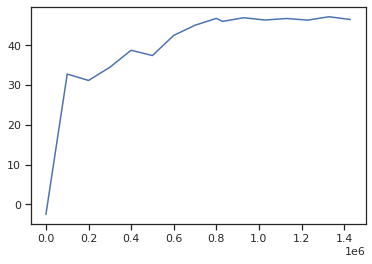

KeyboardInterrupt: 

In [19]:
for i in range(10):
    for i_batch, sample in enumerate(train_dataset):
        
        s = sample['state']
        a = sample['action']
        r = sample['reward']
        next_s = sample['next_state']
        
        agent.update(s,a,r,next_s)
        
        if not i_batch % 100000:
            # agent.alpha *= 0.99
            history.append(np.mean([generate_session(agent, test_env) for _ in range(100)]))
            iters.append(i_iter)
            clear_output(True)
            plt.plot(iters, history)
            plt.show()
        i_iter += 1

In [20]:
%%time
iters = 1000

validation_simple = [{'type': 'simple_agent', 'reward': generate_session(simple_agent, test_env)} for _ in range(iters)]
validation_agent = [{'type': 'agent', 'reward': generate_session(agent, test_env)} for _ in range(iters)]

val_df = pd.DataFrame(validation_simple + validation_agent)

CPU times: user 4min 47s, sys: 108 ms, total: 4min 47s
Wall time: 4min 47s


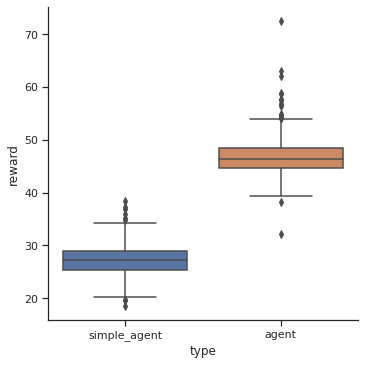

In [21]:
sns.catplot(x="type", y="reward",kind='box', data=val_df);

46.782711020270526


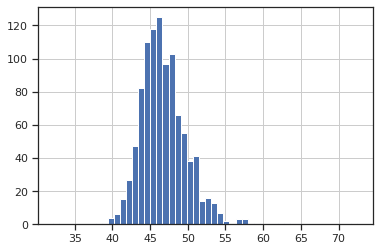

In [22]:
print(val_df.loc[val_df['type'] == 'agent', 'reward'].mean())
val_df.loc[val_df['type'] == 'agent', 'reward'].hist(bins=50);

27.19775790232031


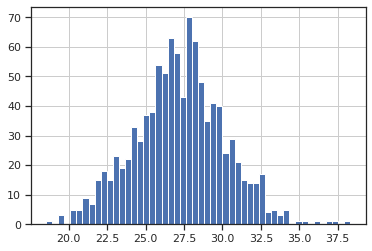

In [23]:
print(val_df.loc[val_df['type'] == 'simple_agent', 'reward'].mean())
val_df.loc[val_df['type'] == 'simple_agent', 'reward'].hist(bins=50);

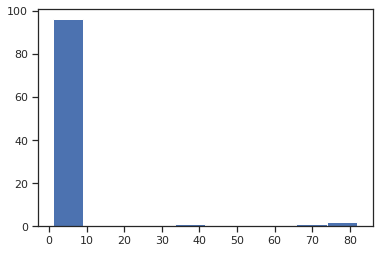

In [24]:
plt.hist([agent.get_best_action(test_env.get_random_state()) for _ in range(100)]);

Сохраним модель в виде словаря Q значений:

In [26]:
qvalues = {}
for key, value in agent._qvalues.items():
    qvalues[key] = dict(value)
pickle.dump(qvalues, open('output/qlearning_model/qvalues.pkl', 'wb'))

Сохраним также модель окружения:

In [27]:
env_dict = {}
for key, value in test_env.env.items():
    env_dict[key] = dict(value)
pickle.dump(env_dict, open('output/env_dict.pkl', 'wb'))